In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras
from keras.regularizers import l2
from keras import regularizers
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import keras
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras import optimizers

In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


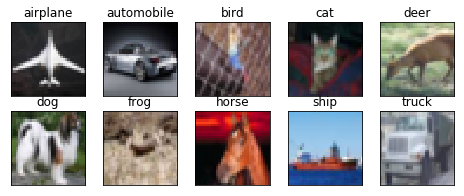

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def get_random_eraser_and_crop(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, random_crop_size=(32, 32), padding_for_crop=4,pixel_level=False):
  
    def random_crop(input_img):
        
        # Note: image_data_format is 'channel_last'
        assert input_img.shape[2] == 3
        
        img = cv2.copyMakeBorder(input_img, padding_for_crop, padding_for_crop, padding_for_crop, padding_for_crop, cv2.BORDER_REPLICATE)
        
        height, width = img.shape[0], img.shape[1]
        
        dy, dx = random_crop_size
        
        x = np.random.randint(0, width - dx + 1)
        
        y = np.random.randint(0, height - dy + 1)
        
        return img[y:(y+dy), x:(x+dx), :]
      
    
    
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
      
    
    def do_preproc(input_image):
      
      return eraser(random_crop(input_image))
      
    return do_preproc

In [0]:
# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,horizontal_flip=True,preprocessing_function=get_random_eraser_and_crop(v_l=0,v_h=1))
# calculate the mean on the training dataset
datagen.fit(train_features)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean,datagen.std))
# calculate the mean on the test dataset
datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen_test.fit(test_features)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean,datagen.std))

#### Given batch size images for datagen object.
#### It will iterate for next next images.

In [13]:
# demonstrate effect on a single batch of samples
train_generator = datagen.flow(train_features,train_labels,batch_size=128,shuffle=False)
batchX, batchy = train_generator.next()
print(batchX.shape,batchX.mean(),batchX.std())

(128, 32, 32, 3) -0.030019887 1.0029794


In [14]:
# demonstrate effect on entire training dataset
test_generator = datagen_test.flow(test_features,test_labels,batch_size=128,shuffle=False)
batchX, batchy = test_generator.next()
print(batchX.shape,batchX.mean(),batchX.std())

(128, 32, 32, 3) -0.032796822 1.0182288


In [15]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

W0804 18:06:40.281787 139874237110144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0804 18:06:40.336122 139874237110144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 18:06:40.344059 139874237110144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 18:06:40.410618 139874237110144 deprecation_wrapper.py

In [16]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [17]:
# For retrieving the saved best results
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

In [0]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [0]:
batch_size = 64
epochs = 10
max_lr = 0.0005
base_lr = max_lr/10
max_m = 0.98
base_m = 0.85

In [0]:
cyclical_momentum = True
augment = True
cycles = 2.35

In [0]:
iterations = round(len(train_features)/batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

In [0]:
from keras import optimizers

In [24]:
model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) 

W0804 18:09:06.763863 139874237110144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 18:09:06.807551 139874237110144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
clr =  CyclicLR(base_lr=base_lr,
                max_lr=max_lr,
                step_size=step_size,
                max_m=max_m,
                base_m=base_m,
                cyclical_momentum=cyclical_momentum)

In [29]:
cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [0]:
mkdir Prajna

In [31]:
cd Prajna

/content/gdrive/My Drive/Prajna


In [0]:
# Defining checkpoints
from keras.callbacks import ModelCheckpoint
filepath="/content/gdrive/My Drive/Prajna-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
callbacks_list.append(clr)

In [33]:
print(train_features.shape)

(50000, 32, 32, 3)


I ran for 8 epochs

In [35]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(50000/128),
        epochs=5,
        validation_data=test_generator,
        callbacks=callbacks_list,
        validation_steps=np.ceil(10000/128)) 

Epoch 1/5
391/391 [==============================] - 29s 75ms/step - loss: 0.3181 - acc: 0.8992 - val_loss: 0.2949 - val_acc: 0.9030

Epoch 00001: val_acc improved from 0.90180 to 0.90297, saving model to /content/gdrive/My Drive/Prajna-01-0.90.hdf5
Epoch 2/5
391/391 [==============================] - 29s 74ms/step - loss: 0.3131 - acc: 0.8999 - val_loss: 0.2912 - val_acc: 0.9033

Epoch 00002: val_acc improved from 0.90297 to 0.90327, saving model to /content/gdrive/My Drive/Prajna-02-0.90.hdf5
Epoch 3/5
391/391 [==============================] - 29s 74ms/step - loss: 0.3083 - acc: 0.9005 - val_loss: 0.2870 - val_acc: 0.9042

Epoch 00003: val_acc improved from 0.90327 to 0.90425, saving model to /content/gdrive/My Drive/Prajna-03-0.90.hdf5
Epoch 4/5
391/391 [==============================] - 29s 74ms/step - loss: 0.3052 - acc: 0.9013 - val_loss: 0.2855 - val_acc: 0.9041

Epoch 00004: val_acc did not improve from 0.90425
Epoch 5/5
391/391 [==============================] - 29s 75ms/step

In [0]:
model1.load_weights('/content/gdrive/My Drive/Prajna-05-0.91.hdf5')

In [0]:
score = model1.evaluate_generator(test_generator,steps=np.ceil(10000/128))

In [40]:
#score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.2820022042274475, 0.9056999789237976]


In [61]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null

  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-oqgpsptm


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from data_science_utils import misc
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
import numpy as np
import cv2

import gc

InteractiveShell.ast_node_interactivity = "all"


In [0]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()


In [0]:
  
  datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
  datagen_validation.fit(X_train)


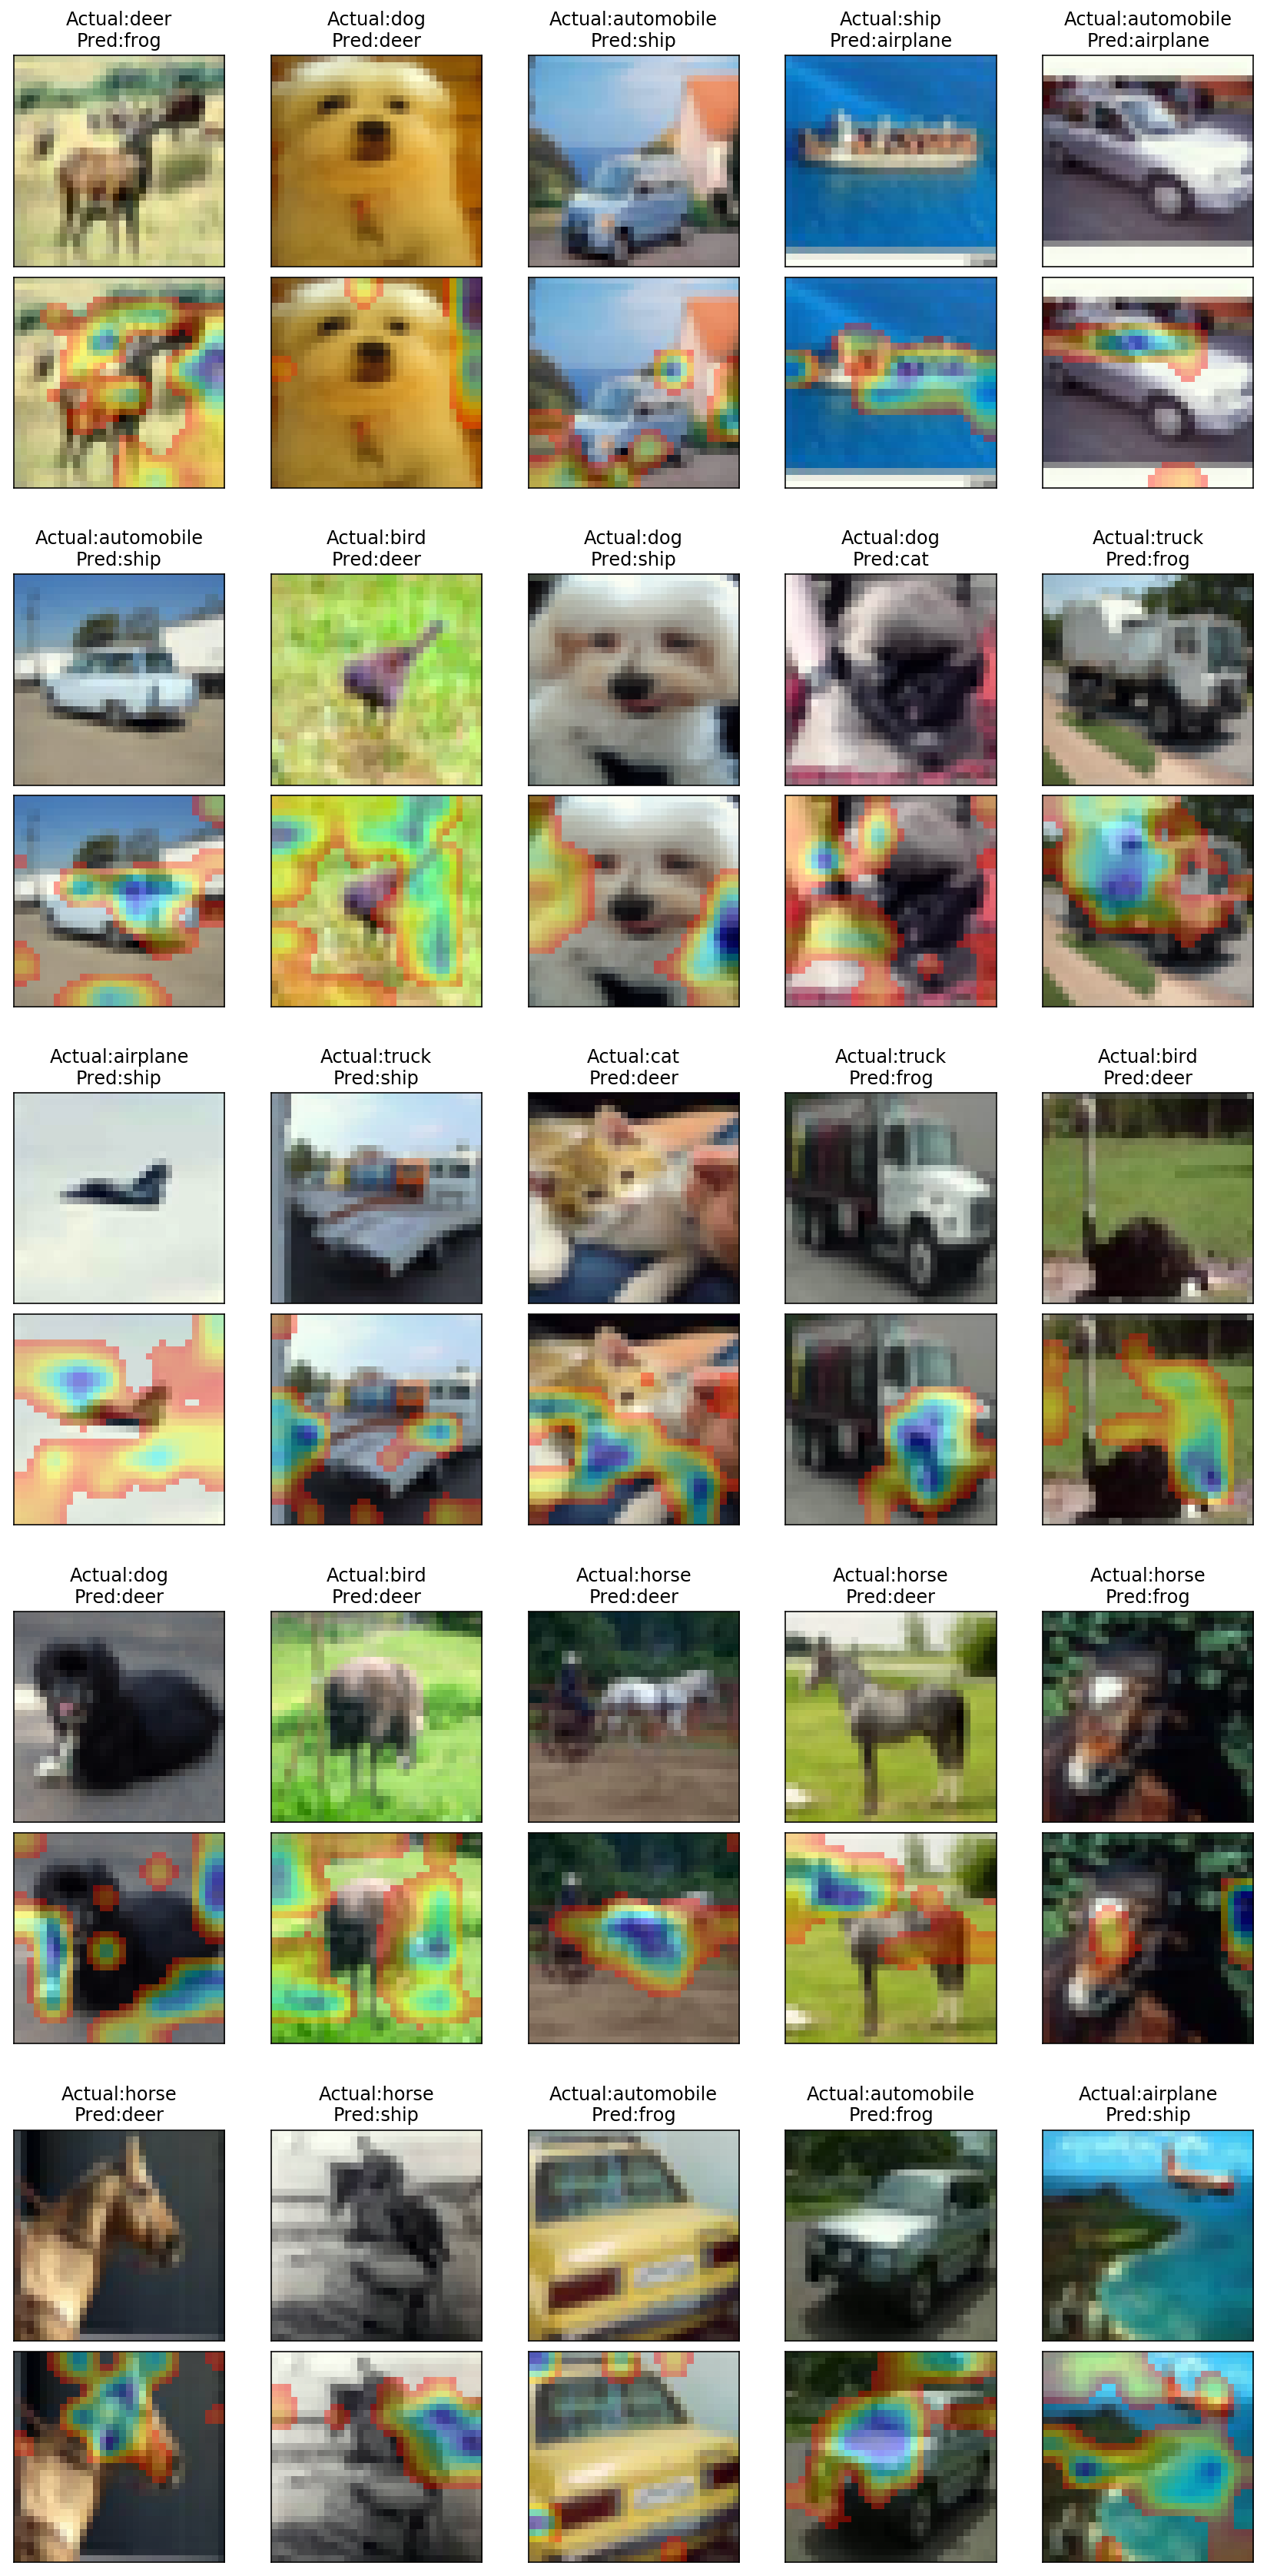

In [63]:
iterator = datagen_validation.flow(X_test, Y_test, batch_size=128, shuffle=False)
show_misclassified_with_gradcam(model1,"conv2d_8",iterator,classes=get_cifar10_labels(),preprocess_func=None,image_size_multiplier=3, examples=25)